In [1]:
!nvidia-smi

Tue Jan 25 13:21:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:81:00.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image

In [3]:
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = 224, 7
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['JPEGImages', 'Annotations', 'ImageSets']

In [4]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')

test_idxs = [int(t) for t in test_i]

with open(DATA_DIR+'/ImageSets/Main/train.txt') as f:
    train_i = f.read().split('\n')

train_idxs = [int(t) for t in train_i]

In [5]:
import albumentations as A
def augment(img_array, anns, nn_crop_size, feature_map_size):
    """Get big crop with bboxes and augment
    return crop for NN and labels """
    big_crop_size, other_size, _ = img_array.shape
    assert big_crop_size == other_size
    bboxes = [ann_to_numpy(a) for a in anns]
    category_ids = [1]*len(bboxes)
    
    bbox_params = A.BboxParams(
        format='pascal_voc',
        label_fields=['category_ids'])
    
    transform = A.Compose([
        A.RandomCrop(nn_crop_size, nn_crop_size),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast()
    ], 
        bbox_params=bbox_params
    )
    
    aug = transform(
        image=img_array, 
        bboxes=bboxes, 
        category_ids=category_ids
    )
    # print(aug['bboxes'])
    aug_y = get_feature_map(
        aug['bboxes'],
        nn_crop_size, 
        feature_map_size)
    
    return aug['image'], aug_y

In [6]:
def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        
def train_gen():
    for i in train_idxs:
        out = crop_sample(i, BIG_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, _, anns = o
            aug_x, aug_y = augment(x, anns, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
            yield aug_x, aug_y

In [7]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_generator(
     train_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

### Test crop_sample()

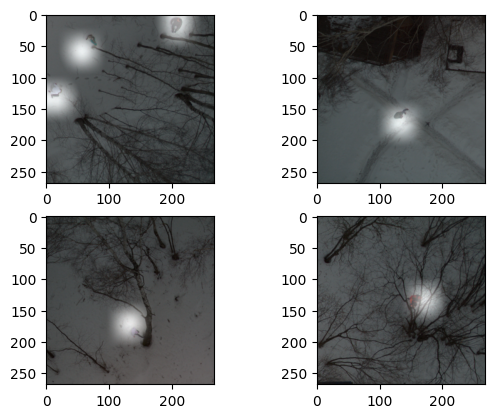

In [8]:
out = crop_sample(0, CROP_SIZE=BIG_CROP_SIZE, FEATURE_MAP_SIZE=FEATURE_MAP_SIZE)

for i in range(4):
    crop_idx, img_arr, y, anns = out[i]
    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((BIG_CROP_SIZE, BIG_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()

### Test dataset

In [9]:
it = iter(test_dataset)

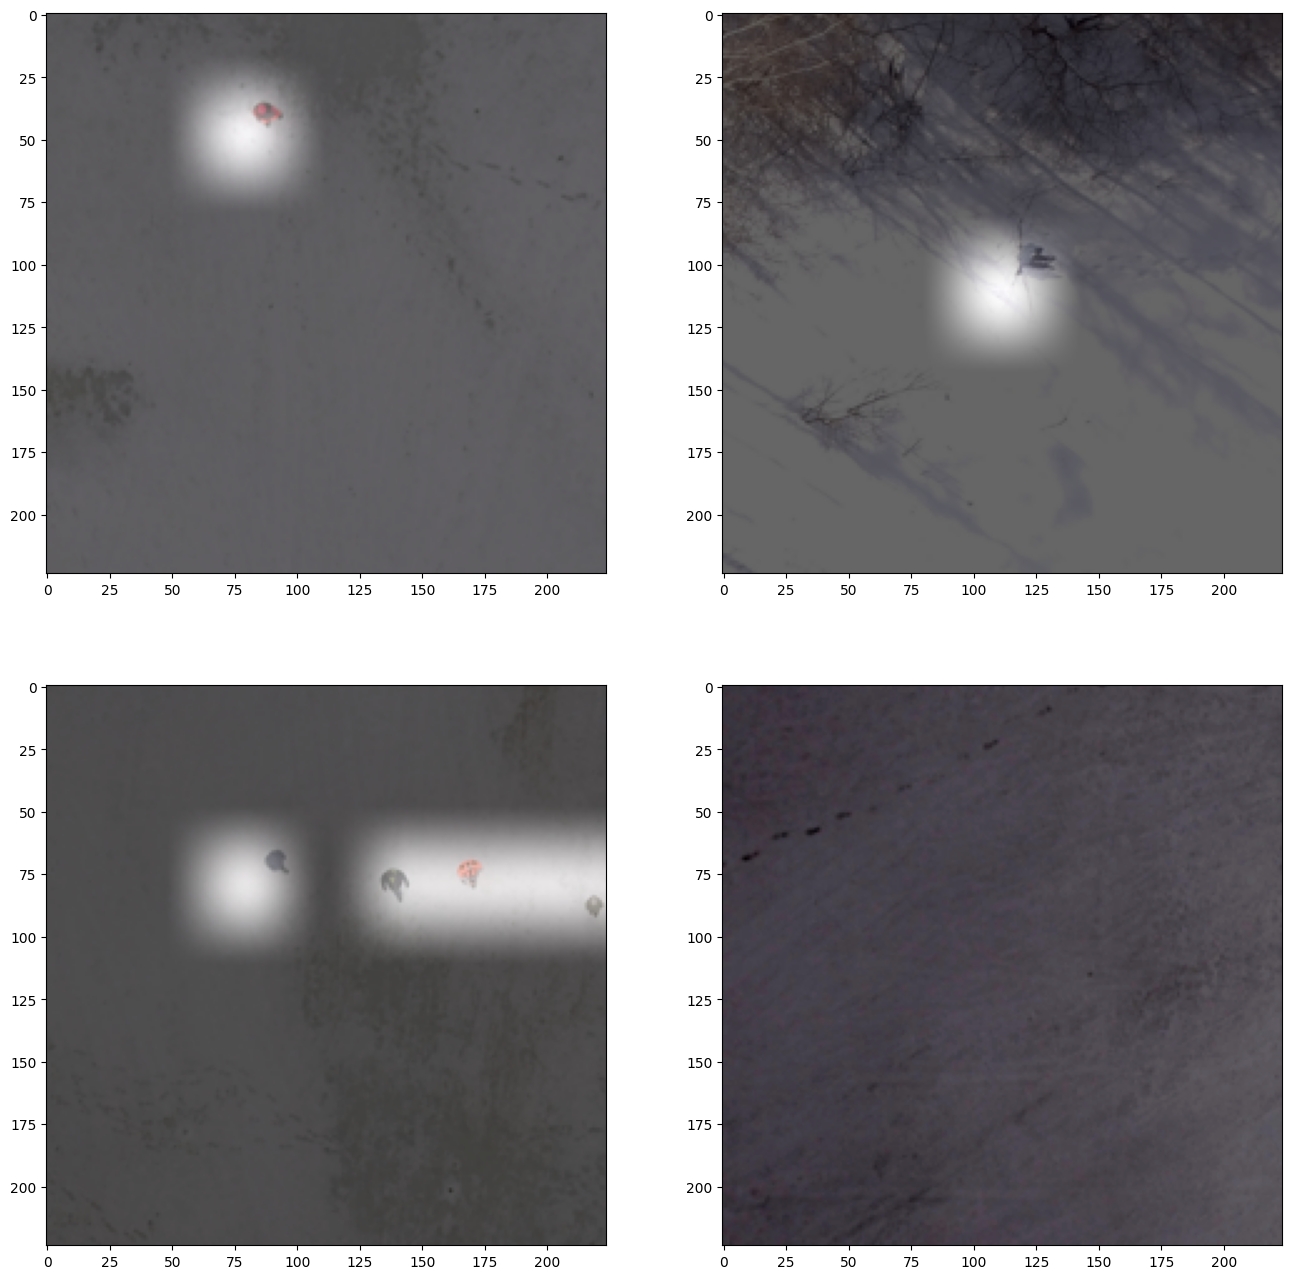

In [10]:
sample = next(it)
sample[0].shape, sample[1].shape
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()

    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()    

### Train dataset

In [11]:
it = iter(train_dataset)

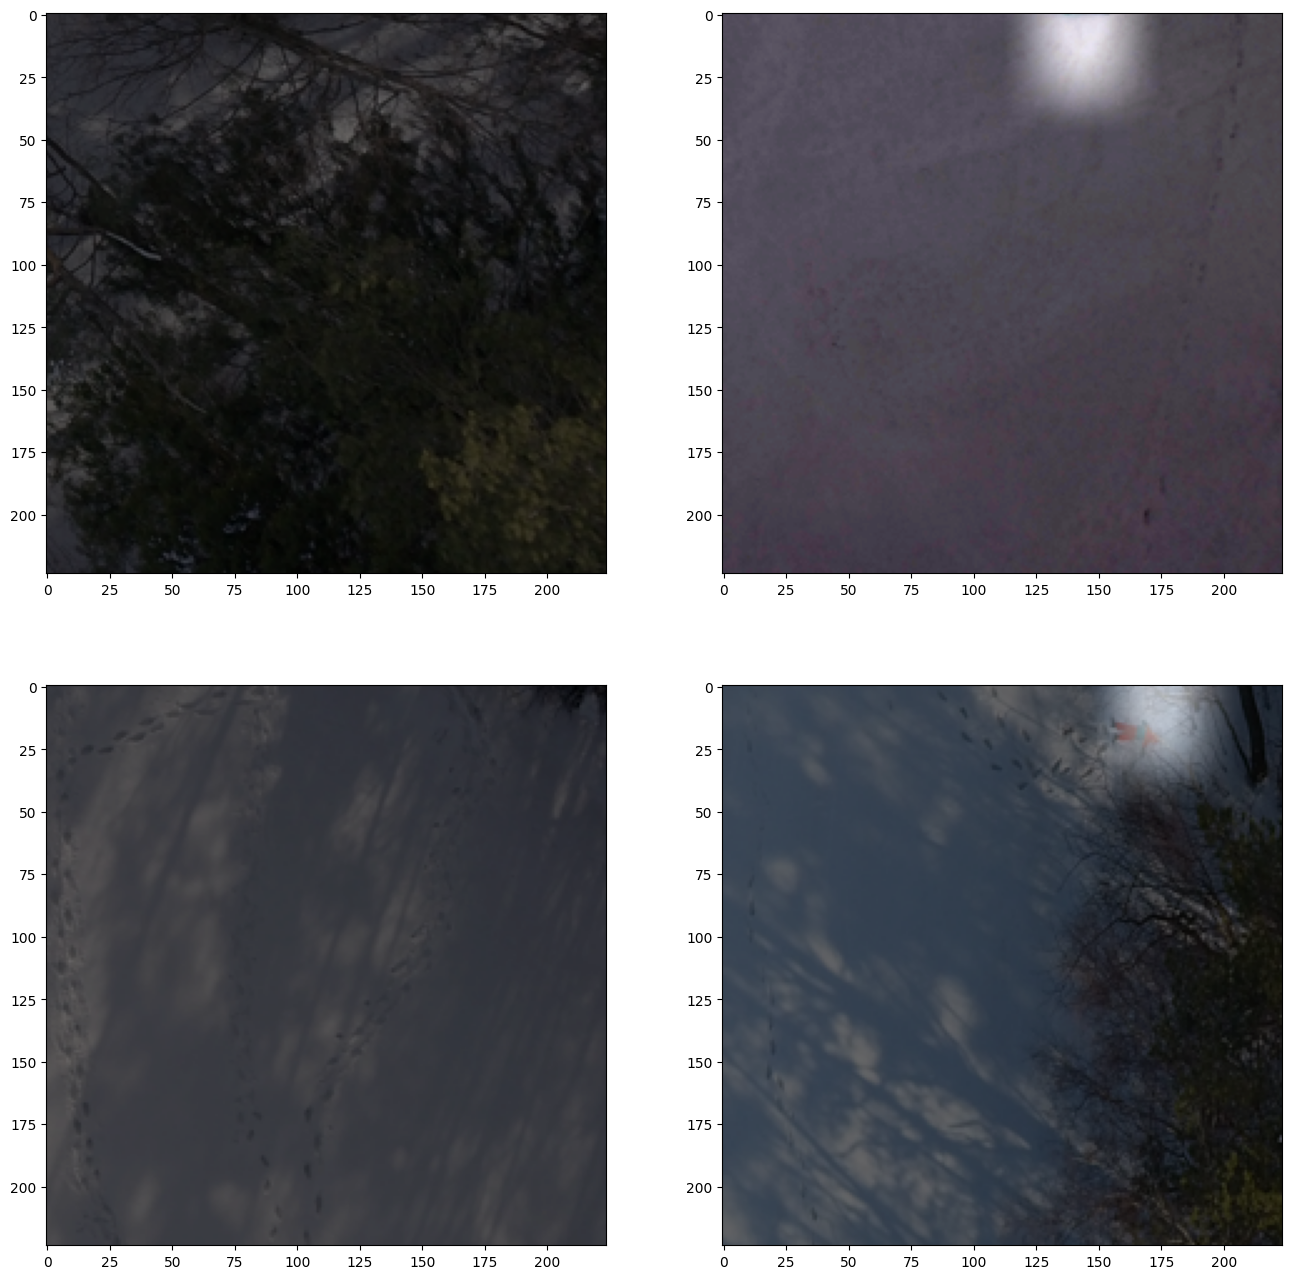

In [12]:
sample = next(it)
sample[0].shape, sample[1].shape
plt.figure(figsize=(16,16))
for i in range(4):
    img_arr = sample[0][i].numpy()
    y = sample[1][i].numpy()

    img = tf.keras.utils.array_to_img(img_arr)

    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))

    plt.subplot(2,2,i+1)
    plt.imshow(Image.blend(y_img.convert('RGBA'), img.convert('RGBA'), alpha=0.4))
plt.show()   

### Backbone loading

In [13]:
model_name = 'MobileNetV3Small'
backbone = tf.keras.models.load_model(f'backbones/{model_name}')

backbone.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   0           ['multiply_14[0][0]']            
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   83088       ['expanded_conv_9/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_

In [14]:
x, y_true = next(it)
# x = tf.expand_dims(x, 0)
y_pred = backbone(x)
y_pred.shape

TensorShape([8, 1, 1, 1024])

### Pedestrian detection model

In [15]:
inputs = backbone.inputs
backbone.trainable = False
out = backbone.get_layer('multiply_17').output
out = tf.keras.layers.Dense(256, activation='relu')(out)
out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
pedet = tf.keras.Model(inputs, out)

In [16]:
THRESH = 0.3
LOG_DIR = f'./logs/GPU1'

precision = tf.keras.metrics.Precision(thresholds=THRESH)
recall = tf.keras.metrics.Recall(thresholds=THRESH)
auc = tf.keras.metrics.AUC()

In [17]:
! rm -rf {LOG_DIR}

In [18]:
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    update_freq='epoch'
)

In [19]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=64000
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
pedet.compile(optimizer=optimizer, 
              loss=focal_loss, 
              metrics=[precision, recall, auc])

In [ ]:
hist = pedet.fit(train_dataset, 
                 validation_data=test_dataset, 
                 epochs=64,
                callbacks=[tbc]
        )

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/64
    356/Unknown - 305s 835ms/step - loss: 4.9556 - precision: 0.2275 - recall: 0.4739 - auc: 0.8005

In [ ]:
pedet.save(f'snapshots/{model_name}')